In [1]:
Sys.getenv("LD_LIBRARY_PATH")

[1] "/home/ubuntu/anaconda3/lib/R/lib:/builddir/vendor/build/lib:/home/ubuntu/anaconda3/jre/lib/amd64/server:/usr/local/cuda-9.2/lib64:/usr/lib64/openmpi/lib/:/usr/local/cuda/lib64:/usr/local/lib:/usr/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/mpi/lib:/lib/:/home/ubuntu/src/cntk/bindings/python/cntk/libs:/usr/local/cuda/lib64:/usr/local/lib:/usr/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/mpi/lib:/usr/lib64/openmpi/lib/:/usr/local/cuda/lib64:/usr/local/lib:/usr/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/mpi/lib:/lib/:/usr/lib64/openmpi/lib/:/usr/local/cuda/lib64:/usr/local/lib:/usr/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/mpi/lib:/lib/:/home/ubuntu/src/cntk/bindings/python/cntk/libs:/usr/local/cuda/lib64:/usr/local/lib:/usr/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/mpi/lib:/usr/lib64/openmpi/lib/:/usr/local/cuda/lib64:/usr/local/lib:/usr/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/mpi/lib:/lib/:"

In [3]:
#### make sure to run  export LD_LIBRARY_PATH=/usr/local/cuda-9.2/lib64  
#### in the terminal 

#system("export LD_LIBRARY_PATH=/usr/local/cuda-9.2/lib64:$LD_LIBRARY_PATH")
library("uroot")
library("forecast")
library("hts")

In [18]:
library("data.table")
library("ggplot2")

In [19]:
input_dir <- "/home/ubuntu/projects/Fee_Impact_2/remi/notebooks/"
fcst_rec<- fread(paste0(input_dir,"python_recon.csv"))[-1,][,algo:="python"]
fcst_no_rec<- fread(paste0(input_dir,"python_indep.csv"))[-1,][,algo:="no_rec"]
colnames(fcst_no_rec)[which(colnames(fcst_no_rec) == "V1")] = "dates"
colnames(fcst_rec)[which(colnames(fcst_rec) == "V1")] = "dates"
#print(fcst_rec,nrow = 5)

In [20]:
#input<- fcst[,-c("V1")]

colnms<- fcst_no_rec[,-c("algo","dates","y0", "y_Consumables", "y_Digital","y_Hardlines","y_Media","y_Softlines")]
colnms<- colnames(colnms)

input<-fcst_no_rec[,list( y0, y_Consumables, y_Digital, y_Hardlines , y_Media, y_Softlines,
                          y_Consumables_121, y_Consumables_194, y_Consumables_325, y_Consumables_unk,
                          y_Digital_400, y_Digital_425, y_Digital_unk,
                          y_Hardlines_107, y_Hardlines_147, y_Hardlines_200, y_Hardlines_201, y_Hardlines_21,y_Hardlines_229,
                          y_Hardlines_23, y_Hardlines_468, y_Hardlines_60, y_Hardlines_79, y_Hardlines_86, y_Hardlines_unk,
                          y_Media_14, y_Media_63, y_Media_74, y_Media_unk,
                          y_Softlines_193, y_Softlines_197, y_Softlines_309, y_Softlines_unk)]
nodes <- list(5, c(4,3,12,4,4))
output<-list()
algs = c("lu", "cg", "chol", "recursive")
i = 1
for (m in algs){
  output[[i]] <-  data.table(combinef(input,nodes, algorithms = m)$bts)
  output[[i]][,c("algo","dates") := list(m,fcst_no_rec$dates)]
  i = i + 1
}

output<- rbindlist(output)
colnames(output)<- c(colnms, "algo","dates")
output[,c("y0", "y_Consumables", "y_Digital","y_Hardlines","y_Media","y_Softlines")  :=
         list(sum(y_Consumables_121, y_Consumables_194, y_Consumables_325, y_Consumables_unk,
                  y_Digital_400, y_Digital_425, y_Digital_unk,
                  y_Hardlines_107, y_Hardlines_147, y_Hardlines_200, y_Hardlines_201, y_Hardlines_21,y_Hardlines_229,
                  y_Hardlines_23, y_Hardlines_468, y_Hardlines_60, y_Hardlines_79, y_Hardlines_86, y_Hardlines_unk,
                  y_Media_14, y_Media_63, y_Media_74, y_Media_unk,
                  y_Softlines_193, y_Softlines_197, y_Softlines_309, y_Softlines_unk),
              sum(y_Consumables_121, y_Consumables_194, y_Consumables_325, y_Consumables_unk),
              sum(y_Digital_400, y_Digital_425, y_Digital_unk),
              sum(y_Hardlines_107, y_Hardlines_147, y_Hardlines_200, y_Hardlines_201, y_Hardlines_21,y_Hardlines_229,
                  y_Hardlines_23, y_Hardlines_468, y_Hardlines_60, y_Hardlines_79, y_Hardlines_86, y_Hardlines_unk),
              sum(y_Media_14, y_Media_63, y_Media_74, y_Media_unk),
              sum(y_Softlines_193, y_Softlines_197, y_Softlines_309, y_Softlines_unk)),
       keyby = list(dates,algo)]


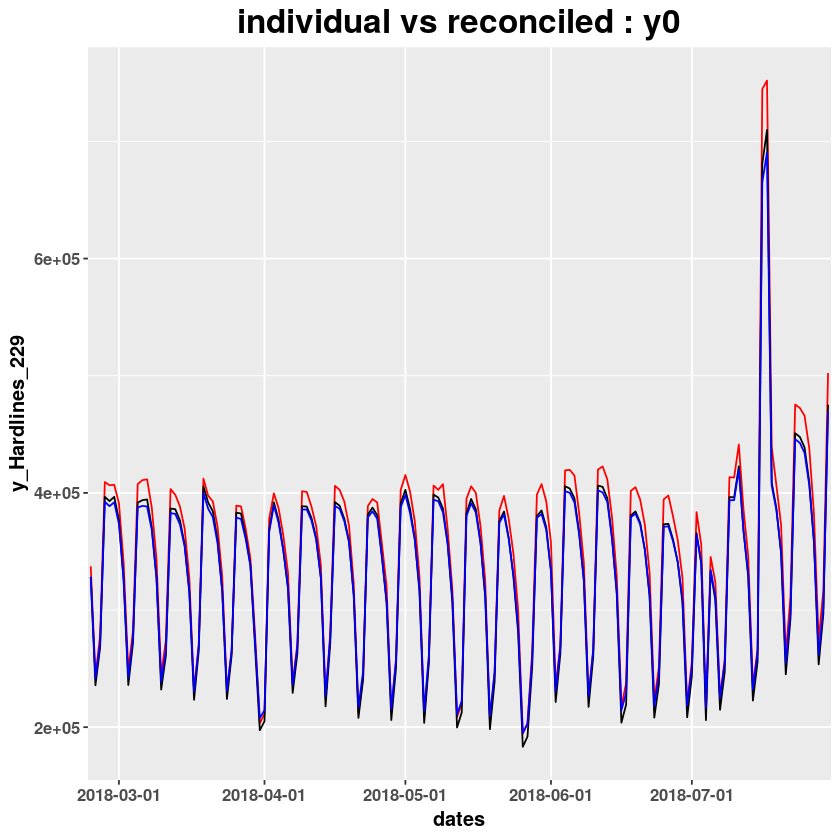

In [21]:


### red = hts
### black = indep
### blue = python recon

ggplot() + 
   geom_line(data = output[algo == "lu"], aes(x = dates, y = y_Hardlines_229 , group = 1), col = "red") +
  geom_line(data = fcst_no_rec[algo == "no_rec"], aes(x = dates, y = y_Hardlines_229 , group = 1), col = "black") +
  geom_line(data = fcst_rec[algo == "python"], aes(x = dates, y = y_Hardlines_229 , group = 1), col = "blue") +
  ggtitle(paste0("individual vs reconciled : ", "y0") ) +
  theme(plot.title = element_text(size = 20, face = "bold", hjust = 0.5) , axis.text=element_text(size=10,face="bold"),
        axis.title=element_text(size=12,face="bold") , 
        legend.text = element_text(colour="blue", size=10, 
                                   face="bold")) +
  scale_color_discrete(name = "ltitle") +
  scale_x_discrete(breaks=c("2018-02-01","2018-03-01","2018-04-01","2018-05-01","2018-06-01", "2018-07-01"))


In [ ]:




#final<- rbind(output,fcst_no_rec, fcst_rec)

#unique(final$algo)

#fwrite(final,paste0(input_dir,"comparison.csv"))

